In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup as bs

In [12]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)
print(train.shape)
print(test.shape)

train = train[ train['Stance'] != 'unrelated' ]
test = test[ test['Stance'] != 'unrelated' ]
print(train.shape)
print(test.shape)

(39905, 4)
(10067, 4)
(10724, 4)
(2703, 4)


       Body ID                                        articleBody  \
0            0  A small meteorite crashed into a wooded area i...   
1            0  A small meteorite crashed into a wooded area i...   
2            0  A small meteorite crashed into a wooded area i...   
3            0  A small meteorite crashed into a wooded area i...   
4            0  A small meteorite crashed into a wooded area i...   
5            0  A small meteorite crashed into a wooded area i...   
6            0  A small meteorite crashed into a wooded area i...   
7            0  A small meteorite crashed into a wooded area i...   
8            0  A small meteorite crashed into a wooded area i...   
9            0  A small meteorite crashed into a wooded area i...   
10           0  A small meteorite crashed into a wooded area i...   
11           5  (NEWSER) – Wonder how long a Quarter Pounder w...   
12           5  (NEWSER) – Wonder how long a Quarter Pounder w...   
13           5  (NEWSER) – Wonder 

In [13]:
def review_to_words(raw_review):
    #Convert the raw review string to a cleaner version taking the steps below
    #Why? So that sklearn's CountVectorizer will accept the review data as input
    
    #remove HTML
    review_text = bs(raw_review, "html.parser").get_text()
    
    #remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    #convert to lowercase and split into individual words
    words = letters_only.lower().split() 
    
    #convert stopwords to a set
    stops = set(stopwords.words("english"))  
    
    #remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    #join words back together
    #(this is just a long string of the words in the review)
    return " ".join(meaningful_words)



In [14]:
train_cleaned_articleBody = train['articleBody'].apply(review_to_words)
train_cleaned_headline = train['Headline'].apply(review_to_words)

test_cleaned_articleBody = test['articleBody'].apply(review_to_words)
test_cleaned_headline = test['Headline'].apply(review_to_words)

In [15]:
df = pd.concat([train_cleaned_articleBody,train_cleaned_headline], axis=1)
df = df.apply(lambda x: x[0]+' '+x[1], axis=1)

df_test = pd.concat([test_cleaned_articleBody, test_cleaned_headline], axis=1)
df_test = df_test.apply(lambda x: x[0]+' '+x[1], axis=1)

In [16]:
vectorizer = CountVectorizer(analyzer = 'word', #look at each word
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 5000) #only use 5000 words max

X_counts_raw = vectorizer.fit_transform(df)
vocab = vectorizer.get_feature_names() #all words present in the review data
vocab_size = len(vocab)


In [17]:
X_counts_raw_test = vectorizer.transform(df_test)

In [18]:
import sys
sys.getsizeof(X_counts_raw)

56

In [21]:
def make_response(stance):
    
    response = [0,0,0]
    if stance == 'agree':
        response[0] = 1
    elif stance == 'disagree':
        response[1] = 1
    elif stance == 'disagree':
        response[2] = 1
    
    return response

In [30]:
y_train = train['Stance'].apply(make_response)
y_train = np.matrix(y_train.tolist())
y_test = test['Stance'].apply(make_response)
y_test = np.matrix(y_test.tolist())

In [31]:
y_train

matrix([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])

In [24]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Conv1D
from keras.initializers import RandomUniform
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
import numpy as np
from tqdm import tqdm

Using TensorFlow backend.


In [36]:
MLP_input = Input(shape=[len(vocab)])
layer = Dense(vocab_size, kernel_initializer='glorot_normal')(MLP_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
layer = Dense(vocab_size//16, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//32, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//64, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = LeakyReLU(0.2)(layer)
#layer = Dropout(0.5)(layer)
layer = Dense(vocab_size//128, kernel_initializer='glorot_normal')(layer)
layer = BatchNormalization()(layer)
layer = Dense(3, kernel_initializer='glorot_normal')(layer)
out = Activation('sigmoid')(layer)

opt = Adam(lr=1e-4)
MLP = Model(MLP_input, out)
MLP.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[metrics.categorical_accuracy])
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 5000)              25005000  
_________________________________________________________________
batch_normalization_25 (Batc (None, 5000)              20000     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 5000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 312)               1560312   
_________________________________________________________________
batch_normalization_26 (Batc (None, 312)               1248      
__________

In [37]:
hist=MLP.fit(X_counts_raw.todense(), y_train,
        epochs=100,
        batch_size=32,
        shuffle=True,
        verbose=2)

Epoch 1/100
14s - loss: 0.2173 - categorical_accuracy: 0.4444
Epoch 2/100
12s - loss: 0.1300 - categorical_accuracy: 0.4759
Epoch 3/100
12s - loss: 0.1094 - categorical_accuracy: 0.4846
Epoch 4/100
12s - loss: 0.1006 - categorical_accuracy: 0.4827
Epoch 5/100
12s - loss: 0.0966 - categorical_accuracy: 0.4964
Epoch 6/100
12s - loss: 0.0918 - categorical_accuracy: 0.5019
Epoch 7/100
12s - loss: 0.0912 - categorical_accuracy: 0.5082
Epoch 8/100
12s - loss: 0.0881 - categorical_accuracy: 0.5186
Epoch 9/100
12s - loss: 0.0857 - categorical_accuracy: 0.5153
Epoch 10/100
12s - loss: 0.0838 - categorical_accuracy: 0.5289
Epoch 11/100
12s - loss: 0.0852 - categorical_accuracy: 0.5283
Epoch 12/100
12s - loss: 0.0824 - categorical_accuracy: 0.5292
Epoch 13/100
12s - loss: 0.0832 - categorical_accuracy: 0.5305
Epoch 14/100
12s - loss: 0.0813 - categorical_accuracy: 0.5448
Epoch 15/100
12s - loss: 0.0807 - categorical_accuracy: 0.5526
Epoch 16/100
12s - loss: 0.0791 - categorical_accuracy: 0.5534
E

In [38]:
import matplotlib.pyplot as plt

In [39]:
y_hat = MLP.predict(X_counts_raw_test.todense())

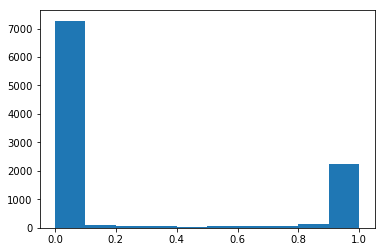

In [41]:
loss = hist.history['loss']
acc = hist.history['categorical_accuracy']

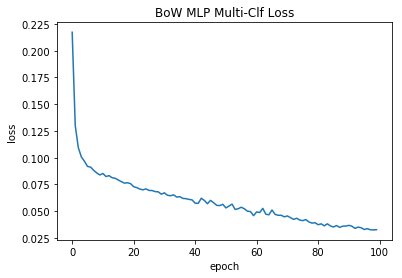

In [42]:
plt.plot(loss)
plt.title('BoW MLP Multi-Clf Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('BoWMLPMultiLoss.png')
plt.show()

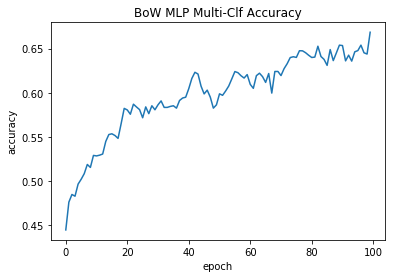

In [43]:
plt.plot(acc)
plt.title('BoW MLP Multi-Clf Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('BoWMLPMultiAcc.png')
plt.show()

In [46]:
y_hat = MLP.predict(X_counts_raw_test.todense())
test['agree']=y_hat[:,0]
test['disagree']=y_hat[:,1]
test['discuss']=y_hat[:,2]
test.to_csv('BoWMLPMulti.csv',index=False)

TypeError: `inputs` should be a list or tuple.

In [21]:
y_hat_classes = [round(i[0]) for i in y_hat]

In [47]:
def get_class_label(scores):
    if scores[0] > scores[1] and scores[0] > scores[2]:
        label='agree'
    elif scores[1] > scores[0] and scores[1] > scores[2]:
        label='disagree'
    else:
        label='discuss'
    return label

In [53]:
y_hat_df = pd.DataFrame(y_hat)
labels = y_hat_df.apply(get_class_label,axis=1)

In [56]:
confusion_matrix(test['Stance'],labels, labels=('agree', 'disagree', 'discuss'))

array([[ 678,   42,    0],
       [  48,  123,    0],
       [1020,  434,  358]])

In [57]:
accuracy_score(test['Stance'],labels)

0.42878283388827226

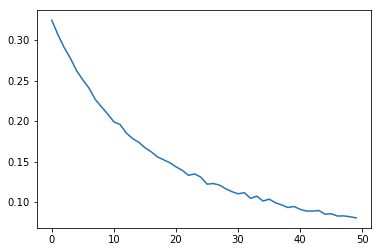

In [33]:
plt.plot(hist.history['loss'])
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
print(y_hat)

In [22]:
cutoff = 1e-20
while cutoff < 1:
    labels = y_hat > cutoff
    labels = [int(i) for i in labels]
    print(cutoff, accuracy_score(y_test, labels))
    cutoff = cutoff * 10

1e-20 0.268501043012
1e-19 0.268501043012
1e-18 0.268501043012
1e-17 0.268501043012
1.0000000000000001e-16 0.268501043012
1e-15 0.268501043012
1.0000000000000002e-14 0.268501043012
1.0000000000000002e-13 0.268501043012
1.0000000000000002e-12 0.268501043012
1.0000000000000001e-11 0.268501043012
1.0000000000000002e-10 0.268501043012
1.0000000000000003e-09 0.268600377471
1.0000000000000004e-08 0.271381742326
1.0000000000000004e-07 0.286182576736
1.0000000000000004e-06 0.343200556273
1.0000000000000004e-05 0.480580113241
0.00010000000000000005 0.668024237608
0.0010000000000000005 0.827456044502
0.010000000000000005 0.916658388795
0.10000000000000006 0.963842256879


In [52]:
y_hat_classes = y_hat < 0.9223
y_hat_classes = [int(i) for i in y_hat_classes]

[  1.00000000e+00   9.99999881e-01   9.99999762e-01   9.99999642e-01
   9.99999523e-01   9.99999404e-01   9.99999285e-01   9.99999166e-01
   9.99999046e-01   9.99998927e-01   9.99998808e-01   9.99998689e-01
   9.99998569e-01   9.99998450e-01   9.99998331e-01   9.99998212e-01
   9.99998093e-01   9.99997973e-01   9.99997854e-01   9.99997616e-01
   9.99997497e-01   9.99997377e-01   9.99997258e-01   9.99997139e-01
   9.99997020e-01   9.99996901e-01   9.99996781e-01   9.99996424e-01
   9.99996305e-01   9.99996185e-01   9.99996066e-01   9.99995947e-01
   9.99995828e-01   9.99995589e-01   9.99995351e-01   9.99995112e-01
   9.99994874e-01   9.99994755e-01   9.99994636e-01   9.99994516e-01
   9.99994278e-01   9.99993801e-01   9.99993682e-01   9.99993443e-01
   9.99993205e-01   9.99993086e-01   9.99992490e-01   9.99992371e-01
   9.99992251e-01   9.99992132e-01   9.99992013e-01   9.99991775e-01
   9.99991417e-01   9.99991298e-01   9.99991179e-01   9.99991059e-01
   9.99990940e-01   9.99990821e-01

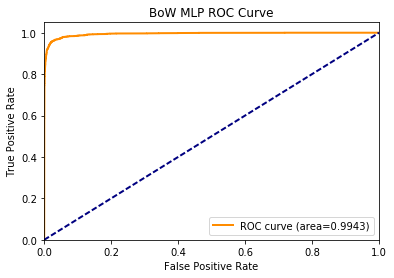

In [24]:

fpr, tpr, _ = roc_curve(y_test, y_hat)

print(_)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BoW MLP ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc-auc-BoW-MLP-binary.png')
plt.show()

In [25]:
for cut in _:
    labels = y_hat > cut
    labels = [int(i) for i in labels]
    print(cut,accuracy_score(y_test, labels))

1.0 0.731498956988
1.0 0.735671004271
1.0 0.737558358995
1.0 0.738452369127
1.0 0.738651038045
0.999999 0.739147710341
0.999999 0.739346379259
0.999999 0.739644382636
0.999999 0.739843051555
0.999999 0.740439058309
0.999999 0.740836396146
0.999999 0.741333068441
0.999999 0.74153173736
0.999998 0.741829740737
0.999998 0.742525081951
0.999998 0.74262441641
0.999998 0.742823085328
0.999998 0.743121088706
0.999998 0.743220423165
0.999998 0.74381642992
0.999997 0.744114433297
0.999997 0.744511771133
0.999997 0.744611105593
0.999997 0.74490910897
0.999997 0.745008443429
0.999997 0.745306446806
0.999997 0.745703784643
0.999996 0.746597794775
0.999996 0.74719380153
0.999996 0.747392470448
0.999996 0.747789808284
0.999996 0.747988477203
0.999996 0.74828648058
0.999996 0.748584483957
0.999995 0.748882487335
0.999995 0.748981821794
0.999995 0.74947849409
0.999995 0.749677163008
0.999995 0.750074500844
0.999995 0.750273169763
0.999994 0.750769842058
0.999994 0.75166385219
0.999994 0.751862521109
0

In [26]:
labels = y_hat > 0.550552
labels = [int(i) for i in labels]

In [28]:
test['BoWMLP']=labels
test.to_csv('BoWMLPBinary.csv',index=False)

In [30]:
confusion_matrix(y_test, labels)
accuracy_score(y_test, labels)

0.97208701698619249

In [112]:
def batch_train_MLP(batch_X, batch_y):
    '''
    train the MLP on the batch
    '''
    
    dense_batch = batch.todense()
    MLP.train_on_batch(batch_X, batch_y)
    

In [113]:
y_train = train['Stance'].apply(lambda x: 0 if x=='unrelated' else 1)
y_test = test['Stance'].apply(lambda x: 0 if x=='unrelated' else 1)

In [114]:
print(y_train)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
39875    0
39876    0
39877    0
39878    0
39879    0
39880    0
39881    0
39882    0
39883    0
39884    0
39885    0
39886    0
39887    0
39888    1
39889    0
39890    1
39891    1
39892    0
39893    0
39894    0
39895    0
39896    0
39897    1
39898    0
39899    0
39900    1
39901    1
39902    1
39903    1
39904    1
Name: Stance, dtype: int64


In [115]:
index = [i for i in range(X_counts_raw.shape[0])]
current = 0.0
batch_frac = 0.05

batch_idx_start = int(current*X_counts_raw.shape[0])
batch_idx_end = int((current+batch_frac)*X_counts_raw.shape[0])

batch_idx = index[batch_idx_start:batch_idx_end]
batch_X = X_counts_raw[batch_idx,:]
batch_X_dense = batch_X.todense()
batch_y = y_train[batch_idx]

print(batch_X_dense.shape)
print(batch_y)

(1995, 5000)
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      1
26      0
27      0
28      0
29      0
       ..
1965    0
1966    0
1967    0
1968    0
1969    0
1970    0
1971    0
1972    0
1973    0
1974    0
1975    0
1976    0
1977    0
1978    0
1979    0
1980    0
1981    1
1982    0
1983    0
1984    0
1985    0
1986    0
1987    0
1988    0
1989    0
1990    0
1991    0
1992    0
1993    0
1994    0
Name: Stance, dtype: int64


In [116]:
index = [i for i in range(X_counts_raw.shape[0])]
np.random.shuffle(index)
loss_vals = []
def train_MLP(num_epochs=1000, batch_frac=0.05):
    
    
    for e in tqdm(range(num_epochs)):
        epoch_loss = []
        current = 0.0
        while (current+batch_frac) <= 1.0:

            batch_idx_start = int(current*X_counts_raw.shape[0])
            batch_idx_end = int((current+batch_frac)*X_counts_raw.shape[0])

            batch_idx = index[batch_idx_start:batch_idx_end]
            batch_X = X_counts_raw[batch_idx,:]
            batch_X_dense = batch_X.todense()
            batch_y = y_train[batch_idx]


            loss = MLP.train_on_batch(batch_X_dense,batch_y)
            epoch_loss.append(loss)
            
            current = current + batch_frac
        print(np.mean(epoch_loss))
        loss_vals.append(np.mean(epoch_loss))
        
    

In [117]:
train_MLP(1000)


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

0.646287



  0%|                                                                               | 1/1000 [00:07<2:04:12,  7.46s/it]


ResourceExhaustedError: OOM when allocating tensor with shape[5000,5000]
	 [[Node: mul_682 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](sub_425, gradients_5/dense_58/MatMul_grad/MatMul_1)]]

Caused by op 'mul_682', defined at:
  File "c:\users\jake\anaconda3\envs\nnets\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\jake\anaconda3\envs\nnets\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-b8d593db0e06>", line 1, in <module>
    train_MLP(1000)
  File "<ipython-input-116-cf8addb376e2>", line 21, in train_MLP
    loss = MLP.train_on_batch(batch_X_dense,batch_y)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\keras\engine\training.py", line 1619, in train_on_batch
    self._make_train_function()
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\keras\engine\training.py", line 1001, in _make_train_function
    self.total_loss)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\keras\optimizers.py", line 398, in get_updates
    m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\ops\math_ops.py", line 794, in binary_op_wrapper
    return func(x, y, name=name)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1015, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1625, in _mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\jake\anaconda3\envs\nnets\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[5000,5000]
	 [[Node: mul_682 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](sub_425, gradients_5/dense_58/MatMul_grad/MatMul_1)]]


In [ ]:
plt.plot(loss_vals)
plt.show()

In [ ]:

y_hat = MLP.predict(X_counts_raw_test.todense())
plt.hist(y_hat)
plt.show()
y_hat_classes = [round(x[0]) for x in y_hat]

[[1784 5580]
 [ 600 2103]]


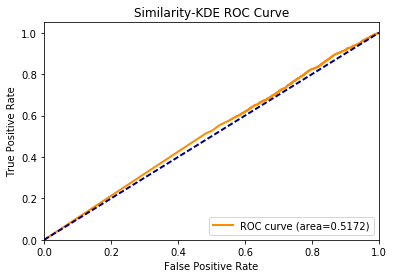

In [97]:
print(confusion_matrix(y_test, y_hat_classes))
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr, color='darkorange',lw=2,label='ROC curve (area=%0.4f)'%roc_auc)
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Similarity-KDE ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc-auc-with-BNSL.png')
plt.show()